# Titanic 生存预测 - 神经网络模型

使用神经网络来预测 Titanic 乘客的生存情况。

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import seaborn as sns

# 设置随机种子以确保结果可复现
np.random.seed(42)
tf.random.set_seed(42)

## 1. 加载和准备数据

In [2]:
# 加载数据
train_data = pd.read_csv('data/processed_train.csv')
test_data = pd.read_csv('data/processed_test.csv')

print("训练集形状:", train_data.shape)
print("测试集形状:", test_data.shape)
print("\n训练集特征:")
print(train_data.columns.tolist())

训练集形状: (891, 18)
测试集形状: (418, 17)

训练集特征:
['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'FamilySize', 'IsAlone', 'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Other']


In [3]:
# 准备特征和目标变量
X = train_data.drop('Survived', axis=1)
y = train_data['Survived']

# 标准化特征
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
test_scaled = scaler.transform(test_data)

# 划分训练集和验证集
X_train, X_val, y_train, y_val = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

print("训练集形状:", X_train.shape)
print("验证集形状:", X_val.shape)

训练集形状: (712, 17)
验证集形状: (179, 17)


## 2. 创建神经网络模型

In [4]:
def create_model(input_shape):
    model = models.Sequential([
        layers.Dense(64, activation='relu', input_shape=input_shape),
        layers.Dropout(0.3),
        layers.Dense(32, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(16, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# 创建模型
model = create_model(input_shape=(X_train.shape[1],))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                1152      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 3777 (14.75 KB)
Trainable params: 3777 (14

## 3. 训练模型

In [5]:
# 添加早停策略
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# 训练模型
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping]
)

Epoch 1/100
23/23 [==============================] - 1s 10ms/step - loss: 0.6846 - accuracy: 0.5520 - val_loss: 0.6207 - val_accuracy: 0.7598
Epoch 2/100
23/23 [==============================] - 0s 3ms/step - loss: 0.5808 - accuracy: 0.7851 - val_loss: 0.5411 - val_accuracy: 0.8101
Epoch 3/100
23/23 [==============================] - 0s 3ms/step - loss: 0.5216 - accuracy: 0.7935 - val_loss: 0.4743 - val_accuracy: 0.8101
Epoch 4/100
23/23 [==============================] - 0s 3ms/step - loss: 0.4641 - accuracy: 0.8090 - val_loss: 0.4471 - val_accuracy: 0.8156
Epoch 5/100
23/23 [==============================] - 0s 3ms/step - loss: 0.4548 - accuracy: 0.8188 - val_loss: 0.4387 - val_accuracy: 0.8101
Epoch 6/100
23/23 [==============================] - 0s 3ms/step - loss: 0.4435 - accuracy: 0.8272 - val_loss: 0.4306 - val_accuracy: 0.8324
Epoch 7/100
23/23 [==============================] - 0s 3ms/step - loss: 0.4422 - accuracy: 0.8188 - val_loss: 0.4260 - val_accuracy: 0.8268
Epoch 8/100


## 4. 评估模型性能

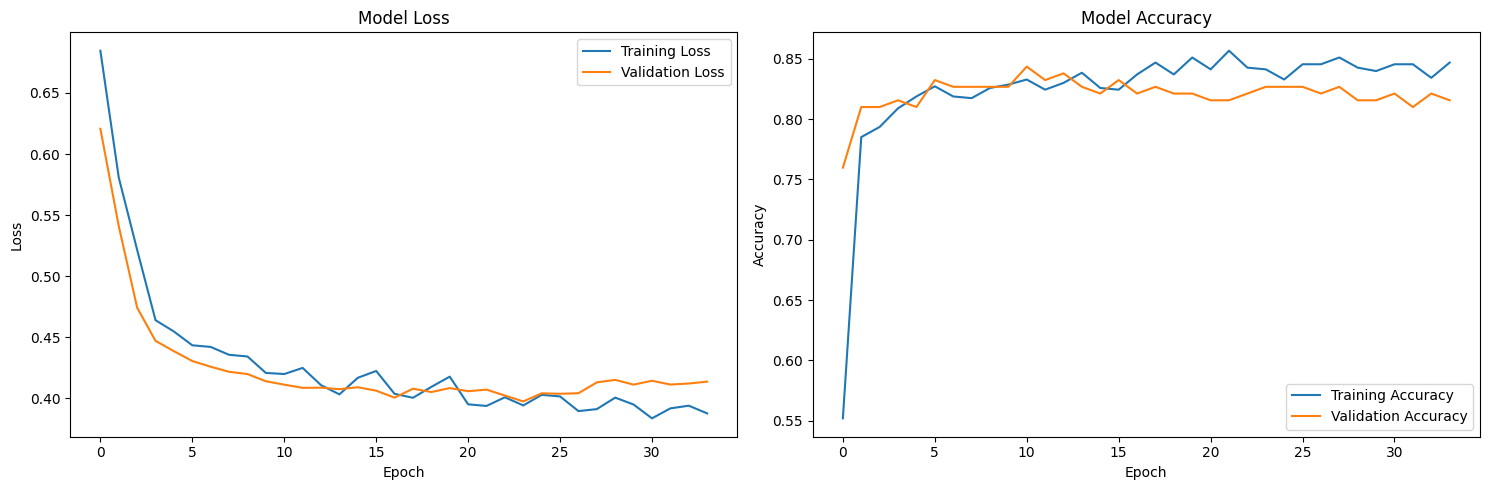

6/6 [==============================] - 0s 2ms/step - loss: 0.3976 - accuracy: 0.8268

验证集准确率: 0.8268


In [6]:
# 绘制训练历史
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# 绘制损失曲线
ax1.plot(history.history['loss'], label='Training Loss')
ax1.plot(history.history['val_loss'], label='Validation Loss')
ax1.set_title('Model Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

# 绘制准确率曲线
ax2.plot(history.history['accuracy'], label='Training Accuracy')
ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax2.set_title('Model Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.tight_layout()
plt.show()

# 打印最终的验证集准确率
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print(f"\n验证集准确率: {val_accuracy:.4f}")

## 5. 生成预测结果

In [7]:
# 生成预测结果
predictions = model.predict(test_scaled)
predictions = (predictions > 0.5).astype(int)

# 创建提交文件
submission = pd.DataFrame({
    'PassengerId': range(892, 892 + len(predictions)),
    'Survived': predictions.flatten()
})

submission.to_csv('data/nn_submission.csv', index=False)
print("预测结果已保存到 'nn_submission.csv'")
submission.head()

14/14 [==============================] - 0s 1ms/step
预测结果已保存到 'nn_submission.csv'


,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
